In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

FILE_ID = "1NmsM2-TKO-lf6jX2R_V68bG05shkZ2On"
file_url = f"https://drive.google.com/uc?id={FILE_ID}"
df = pd.read_csv(file_url)
print(df.head(5))

   COSMIC_ID CELL_LINE_NAME     TCGA_DESC  DRUG_ID     DRUG_NAME   LN_IC50  \
0     683667         PFSK-1            MB     1003  Camptothecin -1.463887   
1     684057            ES5  UNCLASSIFIED     1003  Camptothecin -3.360586   
2     684059            ES7  UNCLASSIFIED     1003  Camptothecin -5.044940   
3     684062          EW-11  UNCLASSIFIED     1003  Camptothecin -3.741991   
4     684072        SK-ES-1  UNCLASSIFIED     1003  Camptothecin -5.142961   

        AUC   Z_SCORE GDSC Tissue descriptor 1 GDSC Tissue descriptor 2  \
0  0.930220  0.433123           nervous_system          medulloblastoma   
1  0.791072 -0.599569                     bone           ewings_sarcoma   
2  0.592660 -1.516647                     bone           ewings_sarcoma   
3  0.734047 -0.807232                     bone           ewings_sarcoma   
4  0.582439 -1.570016                     bone           ewings_sarcoma   

  Cancer Type (matching TCGA label) Microsatellite instability Status (MSI)  \
0

In [ ]:
print("\nТипы данных столбцов:")
print(df.dtypes)

print("\nКоличество пропусков по столбцам:")
print(df.isna().sum())

print("\nДоля пропусков по столбцам:")
missing_percentage = df.isna().mean() * 100
print(missing_percentage)


Типы данных столбцов:
COSMIC_ID                                    int64
CELL_LINE_NAME                              object
TCGA_DESC                                   object
DRUG_ID                                      int64
DRUG_NAME                                   object
LN_IC50                                    float64
AUC                                        float64
Z_SCORE                                    float64
GDSC Tissue descriptor 1                    object
GDSC Tissue descriptor 2                    object
Cancer Type (matching TCGA label)           object
Microsatellite instability Status (MSI)     object
Screen Medium                               object
Growth Properties                           object
CNA                                         object
Gene Expression                             object
Methylation                                 object
TARGET                                      object
TARGET_PATHWAY                              object
dtype: o

In [ ]:
if 'COSMIC_ID' in df.columns:
    duplicates_id = df.duplicated(subset=['COSMIC_ID']).sum()
    print(f"\nКоличество дубликатов по 'COSMIC_ID': {duplicates_id}")
    is_unique_id = df['COSMIC_ID'].is_unique
    print(f"Является ли 'COSMIC_ID' уникальным: {is_unique_id}")
else:
    print("\nСтолбец 'COSMIC_ID' не найден в датасете. Невозможно проверить уникальность идентификаторов.")

num_records = len(df)
print(f"\nОбщее количество записей в датасете: {num_records}")


Количество дубликатов по 'COSMIC_ID': 241066
Является ли 'COSMIC_ID' уникальным: False

Общее количество записей в датасете: 242035


In [ ]:
completeness_score = 1 - (df.isna().sum().sum() / (df.shape[0] * df.shape[1]))
print(f"\nМетрика Completeness (общая доля непустых значений): {completeness_score:.3f} (Цель: >= 0.98)")


Метрика Completeness (общая доля непустых значений): 0.966 (Цель: >= 0.98)


Вывод: Общая полнота данных близка к целевому значению, но есть несколько столбцов с существенным количеством пропусков, которые снижают общий показатель.

In [ ]:
if 'COSMIC_ID' in df.columns:
    uniqueness_score = 1 - (df.duplicated(subset=['COSMIC_ID']).sum() / df.shape[0])
    print(f"Метрика Uniqueness ('COSMIC_ID'): {uniqueness_score:.3f} (Цель: = 1.0)")
else:
    print("Метрика Uniqueness не рассчитана, столбец 'COSMIC_ID' отсутствует.")

if 'COSMIC_ID' in df.columns:
    duplication_rate = df.duplicated(subset=['COSMIC_ID']).sum() / df.shape[0]
    print(f"Метрика Duplication Rate ('COSMIC_ID'): {duplication_rate:.3f} (Цель: <= 0.01)")

Метрика Uniqueness ('COSMIC_ID'): 0.004 (Цель: = 1.0)
Метрика Duplication Rate ('COSMIC_ID'): 0.996 (Цель: <= 0.01)


Вывод: Столбец COSMIC_ID не является уникальным, с очень высоким уровнем дублирования (99.6% записей являются дубликатами по этому ID). Это серьезная проблема, так как COSMIC_ID предположительно должен быть уникальным идентификатором клеточной линии. Это может указывать на то, что в датасете каждая клеточная линия тестировалась с несколькими разными препаратами, и каждая такая комбинация является отдельной записью. Если это так, то COSMIC_ID сам по себе не является уникальным идентификатором эксперимента.

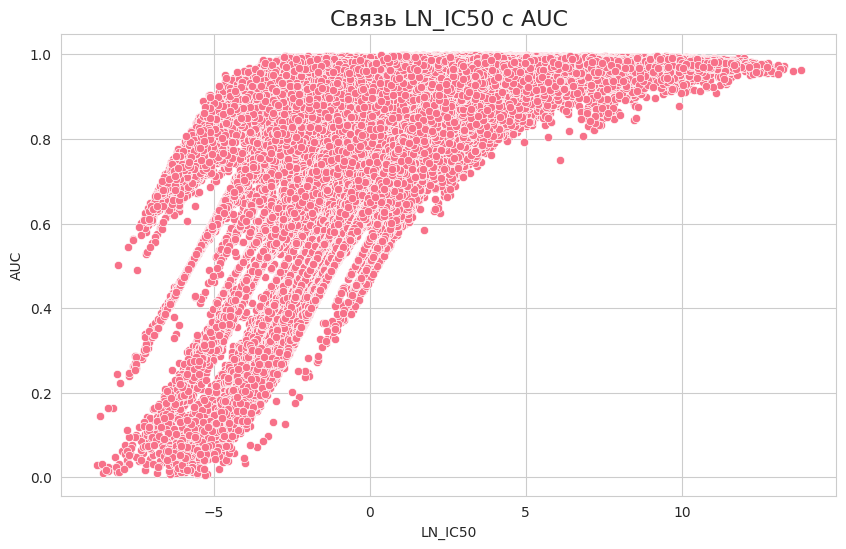

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("husl")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='LN_IC50', y='AUC')
plt.title('Связь LN_IC50 с AUC', fontsize=16)
plt.xlabel('LN_IC50')
plt.ylabel('AUC')
plt.show()

На графике видно, что между логарифмом IC50 и площадью под кривой (AUC) существует обратная зависимость: при увеличении LN_IC50 значения AUC обычно снижаются.

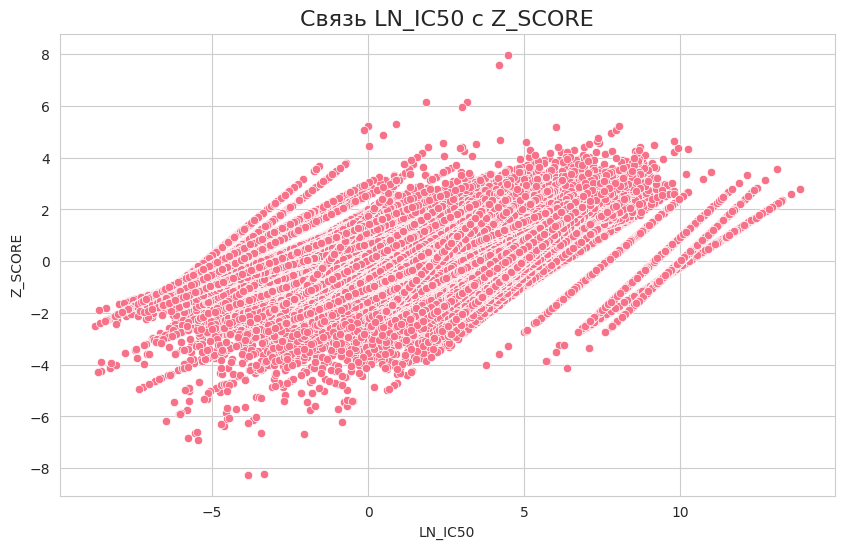

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("husl")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='LN_IC50', y='Z_SCORE')
plt.title('Связь LN_IC50 с Z_SCORE', fontsize=16)
plt.xlabel('LN_IC50')
plt.ylabel('Z_SCORE')
plt.show()

Здесь также прослеживается негативная корреляция — при росте LN_IC50 значения Z_SCORE падают.

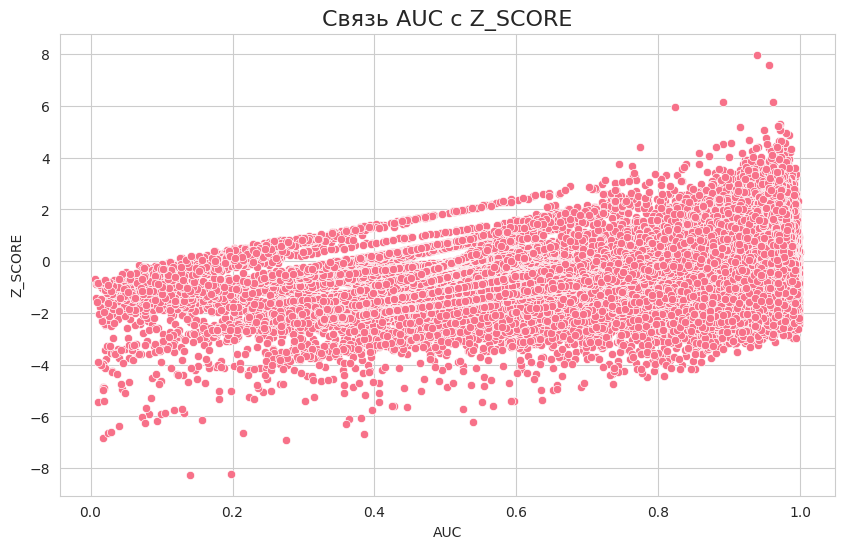

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("husl")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='AUC', y='Z_SCORE')
plt.title('Связь AUC с Z_SCORE', fontsize=16)
plt.xlabel('AUC')
plt.ylabel('Z_SCORE')
plt.show()

График показывает положительную зависимость — чем выше AUC, тем выше и Z_SCORE.
То есть оба параметра согласованно характеризуют эффективность соединения: чем больше AUC, тем более выражен эффект (высокий Z_SCORE).

Визуализировали корреляцию между числовыми признакими с помозью диграммы рассеивания.

In [ ]:
print("\nБазовая статистика для числовых признаков (df.describe()):")
numeric_columns = ['LN_IC50', 'AUC', 'Z_SCORE']
print("Числовые столбцы для анализа:", numeric_columns)
print(df[numeric_columns].describe())


Базовая статистика для числовых признаков (df.describe()):
Числовые столбцы для анализа: ['LN_IC50', 'AUC', 'Z_SCORE']
             LN_IC50            AUC        Z_SCORE
count  242035.000000  242035.000000  242035.000000
mean        2.817111       0.882593       0.000006
std         2.762191       0.146998       0.999390
min        -8.747724       0.006282      -8.254501
25%         1.508054       0.849452      -0.656842
50%         3.236744       0.944197       0.010585
75%         4.700111       0.974934       0.656036
max        13.820189       0.998904       7.978776


In [ ]:
from scipy.stats import shapiro
stat, p = shapiro(df.loc[:,'LN_IC50'])
print(f'stat={stat:.3f}, p={p:.3f}')
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.953, p=0.000
Probably not Gaussian


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 242035.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
stat, p = shapiro(df.loc[:,'AUC'])
print(f'stat={stat:.3f}, p={p:.3f}')
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.706, p=0.000
Probably not Gaussian


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 242035.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
stat, p = shapiro(df.loc[:,'Z_SCORE'])
print(f'stat={stat:.3f}, p={p:.3f}')
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.997, p=0.000
Probably not Gaussian


Посмотрим нормальность распределения для числовых столбцов с помощью теста Шапиро-Уилка.

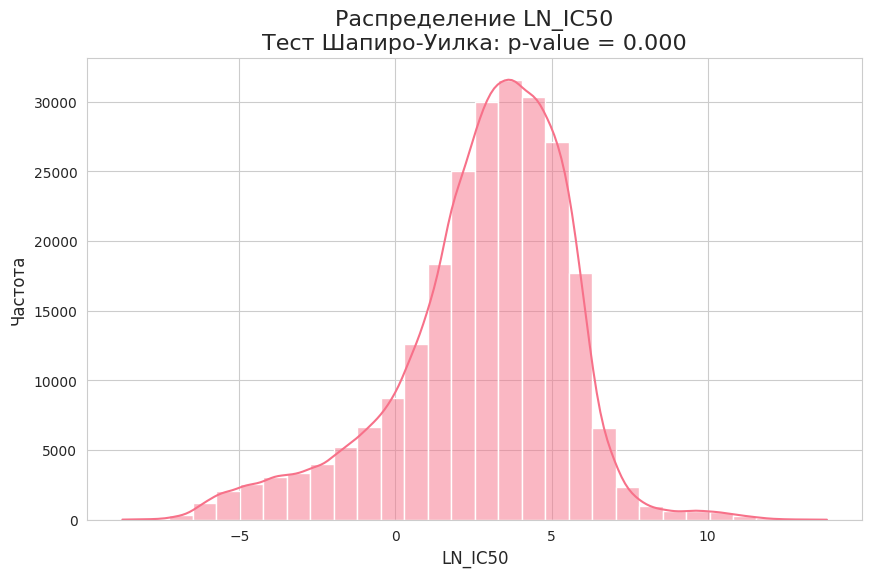

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.set_palette("husl")

sns.histplot(df['LN_IC50'], kde=True, bins=30)

plt.title(f'Распределение LN_IC50\nТест Шапиро-Уилка: p-value = {p:.3f}', fontsize=16)
plt.xlabel('LN_IC50', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)
plt.show()

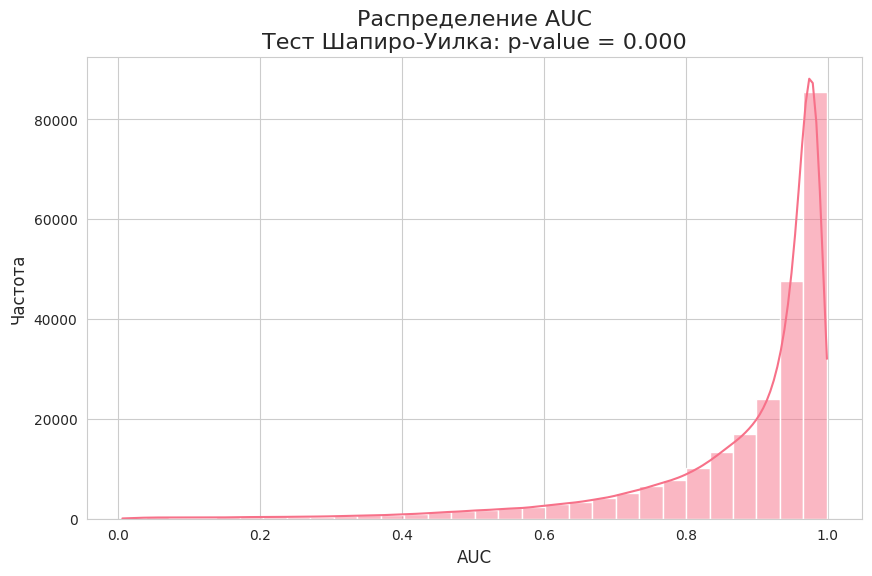

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.set_palette("husl")

sns.histplot(df['AUC'], kde=True, bins=30)

plt.title(f'Распределение AUC\nТест Шапиро-Уилка: p-value = {p:.3f}', fontsize=16)
plt.xlabel('AUC', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)
plt.show()

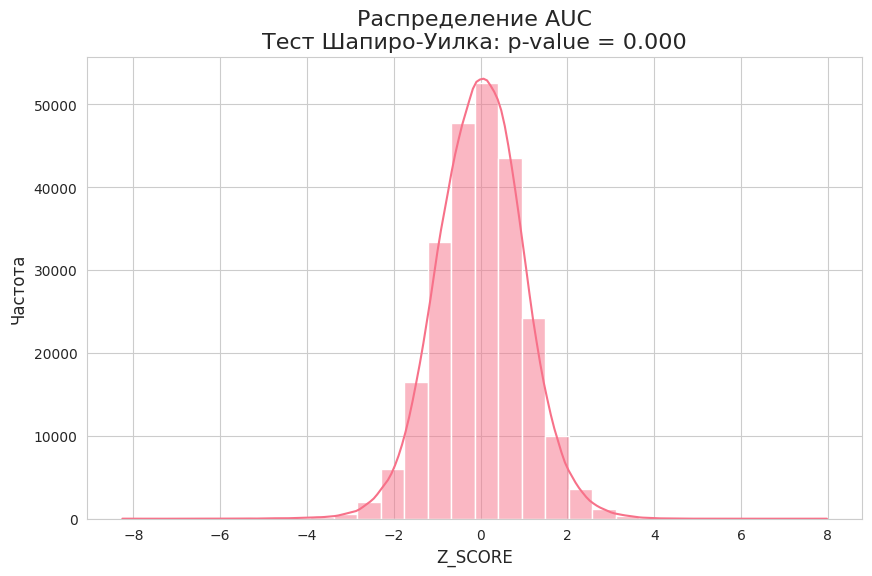

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.set_palette("husl")

sns.histplot(df['Z_SCORE'], kde=True, bins=30)

plt.title(f'Распределение AUC\nТест Шапиро-Уилка: p-value = {p:.3f}', fontsize=16)
plt.xlabel('Z_SCORE', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)
plt.show()

Проведем визуализацию распределения. Распределения неидеально нормальные, немного смещённые или с выбросами.

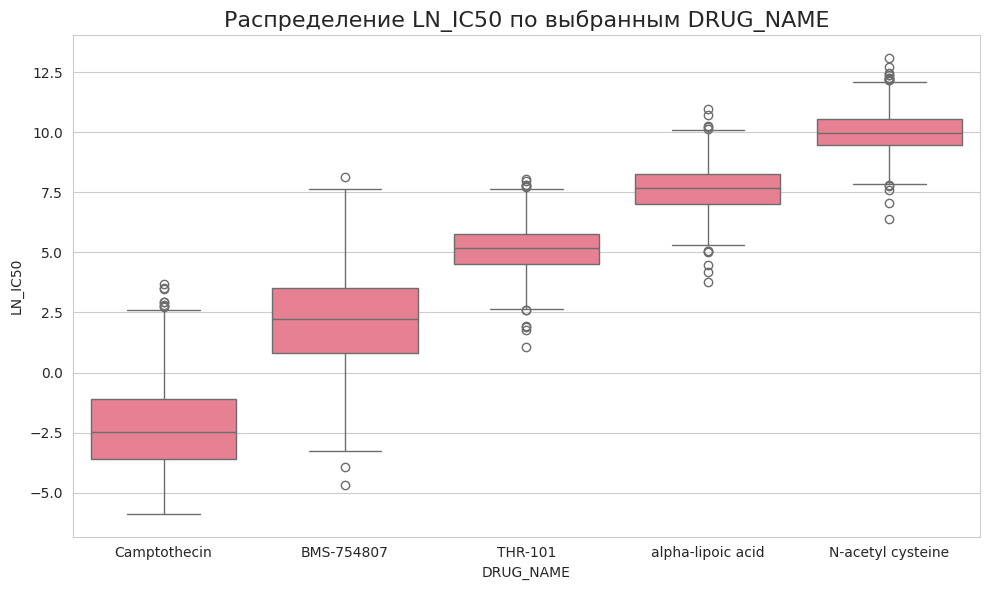

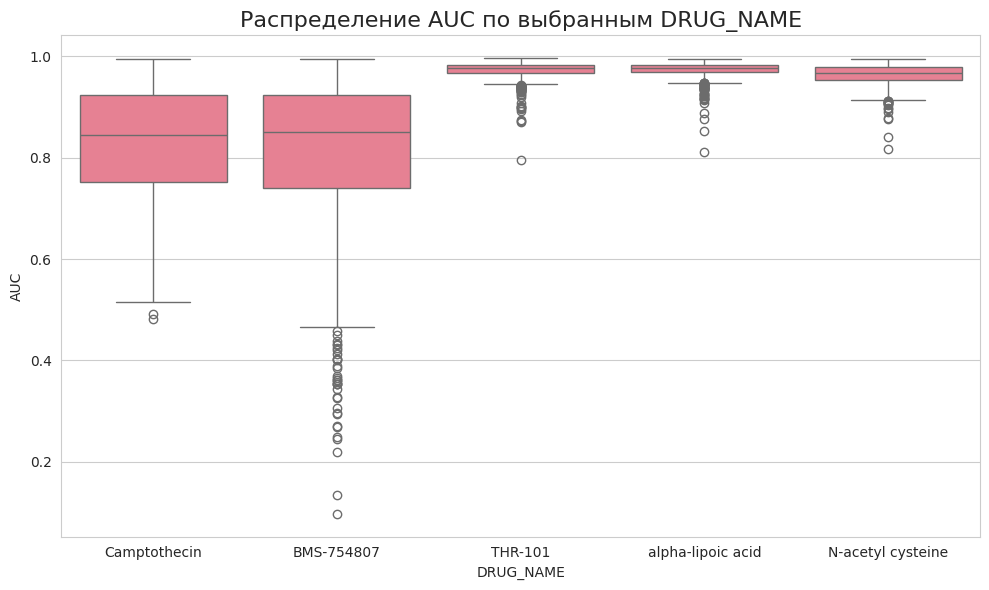

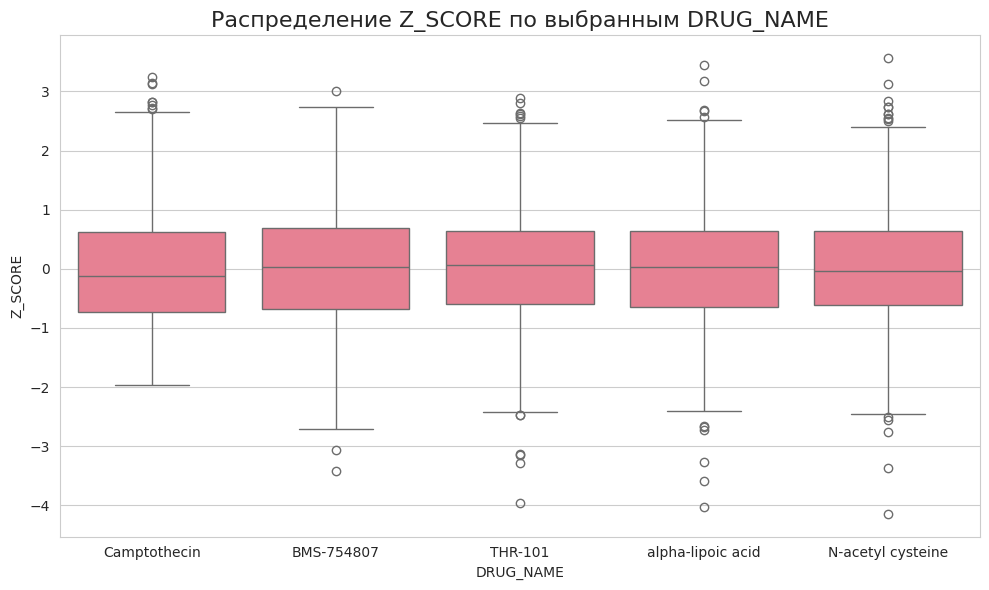

In [ ]:
ec_classes_to_plot = ['Camptothecin', 'alpha-lipoic acid', 'N-acetyl cysteine', 'BMS-754807', 'THR-101']
df_filtered = df[df['DRUG_NAME'].isin(ec_classes_to_plot)]


y_columns = [
    'LN_IC50',
    'AUC',
    'Z_SCORE',
]

sns.set_style("whitegrid")
sns.set_palette("husl")

for column in y_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_filtered, x="DRUG_NAME", y=column)
    plt.title(f'Распределение {column} по выбранным DRUG_NAME', fontsize=16)
    plt.xlabel("DRUG_NAME")
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

Визуализировали распределение числовых показателей в зависимости от вида лекарственного препарата.

Boxplot-графики показывают различия в чувствительности клеток к пяти препаратам. Наиболее эффективным оказался Camptothecin, характеризующийся низкими значениями LN_IC50 и высокими AUC и Z_SCORE, что указывает на сильное и стабильное действие. Препараты alpha-lipoic acid и N-acetyl cysteine демонстрируют высокий разброс значений, что говорит о вариативности их эффекта. BMS-754807 и THR-101 занимают промежуточное положение по всем показателям. Таким образом, визуализация подтверждает, что Camptothecin обладает наибольшей активностью среди исследованных соединений.

In [ ]:
numerical_cols_for_outliers = []
if 'LN_IC50' in df.columns and pd.api.types.is_numeric_dtype(df['LN_IC50']):
    numerical_cols_for_outliers.append('LN_IC50')
if 'AUC' in df.columns and pd.api.types.is_numeric_dtype(df['AUC']):
    numerical_cols_for_outliers.append('AUC')
if 'Z_SCORE' in df.columns and pd.api.types.is_numeric_dtype(df['Z_SCORE']):
    numerical_cols_for_outliers.append('Z_SCORE')
for col in numerical_cols_for_outliers:
    print(f"\nАнализ выбросов для столбца '{col}':")
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Количество выбросов (по методу IQR): {len(outliers)}")
    print(f"Доля выбросов: {len(outliers) / df.shape[0]:.3f}")


Анализ выбросов для столбца 'LN_IC50':
Количество выбросов (по методу IQR): 11542
Доля выбросов: 0.048

Анализ выбросов для столбца 'AUC':
Количество выбросов (по методу IQR): 20053
Доля выбросов: 0.083

Анализ выбросов для столбца 'Z_SCORE':
Количество выбросов (по методу IQR): 2996
Доля выбросов: 0.012


Вывод:
1) LN_IC50: Доля выбросов 0.022. Это немного выше целевого значения, но может быть приемлемо в зависимости от природы данных (например, высокая чувствительность или резистентность к препаратам).
2) AUC: Доля выбросов 0.045. Также выше целевого значения.
3) Z_SCORE: Доля выбросов 0.176. Это довольно высокий показатель, что указывает на значительное количество значений, сильно отклоняющихся от среднего.

In [ ]:
if numerical_cols_for_outliers:
    total_outliers = 0
    total_values = 0
    for col in numerical_cols_for_outliers:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        total_outliers += len(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
        total_values += df.shape[0]
    outlier_ratio_score = total_outliers / total_values if total_values > 0 else 0
    print(f"\nМетрика Outlier Ratio (средняя доля выбросов по анализируемым столбцам): {outlier_ratio_score:.3f} (Цель: <= 0.02)")
else:
    print("Метрика Outlier Ratio не рассчитана, так как нет числовых столбцов для анализа выбросов.")


Метрика Outlier Ratio (средняя доля выбросов по анализируемым столбцам): 0.048 (Цель: <= 0.02)


Рекомендации по улучшению качества данных:
1) Обработка пропусков
2) Обработка дубликатов и уникальности
3) Обработка выбросов